In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt


G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

In [2]:
# load data
TrainingData = scio.loadmat('../generate_ligo/noise.mat') # only noise    
analysisData = scio.loadmat('../generate_ligo/data.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
# dataY = analysisData['dataVec'][0] # (2048,)
dataY = analysisData['data'][0]
# dataY = analysisData['trainData'][0] # (2048,)1
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
# Fs = analysisData['sampFreq'][0,0] # 1024
Fs = analysisData['samples'][0]
# Fs = 300
# Search range of phase coefficients
"""
        r(Mpc),m_c(Msun), tc(s),phi_c,mlz(Msun),y
"""
rmin = [0,1.1,0,0,4,0]
rmax = [4000,1000,1,2*np.pi,14,10]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
# t = np.arange(0, nSamples*dt, dt) # (2048,)

t = np.linspace(-100,0,nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['noise'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

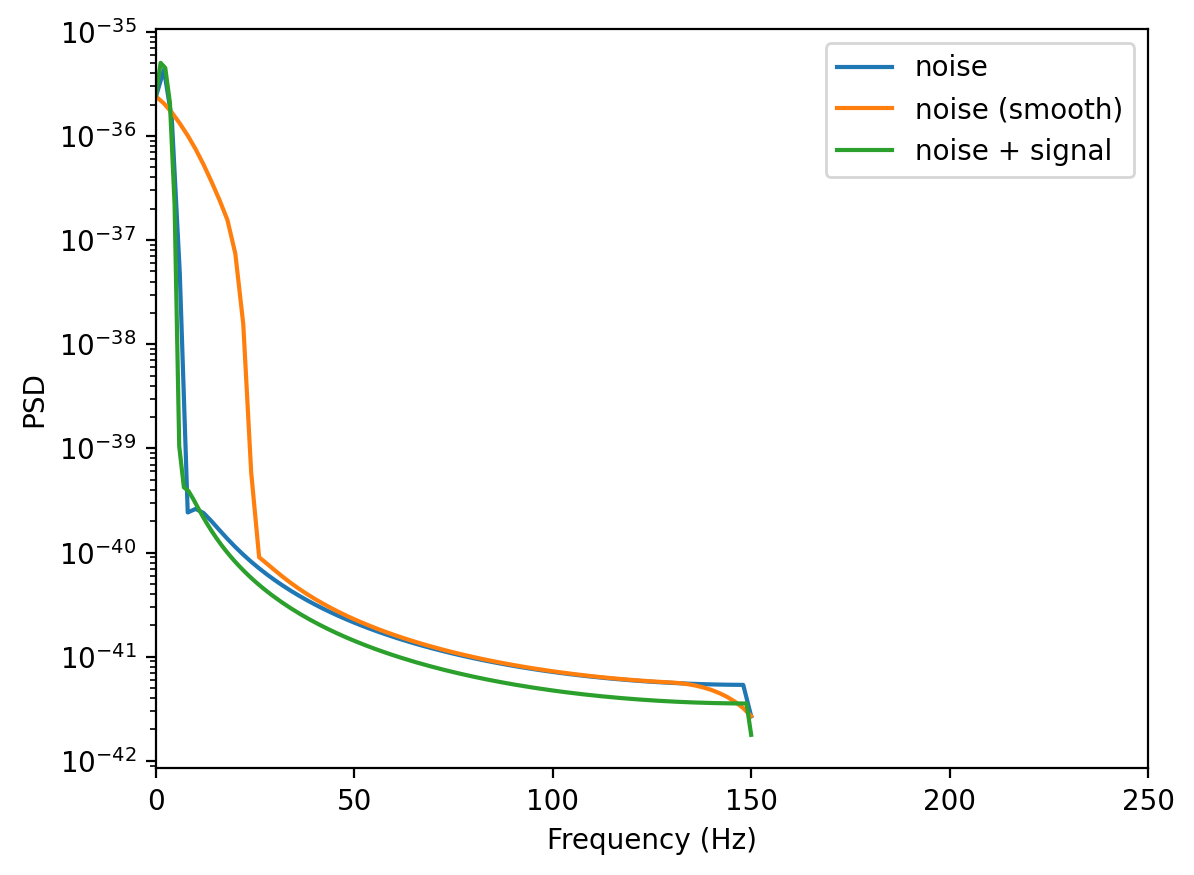

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smooth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(np.abs(f),pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0,250)
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    # 'dataXSq': t**2,
    # 'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from itsw
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 3000}, nRuns)

100%|██████████| 3000/3000 [16:30<00:00,  3.03it/s]


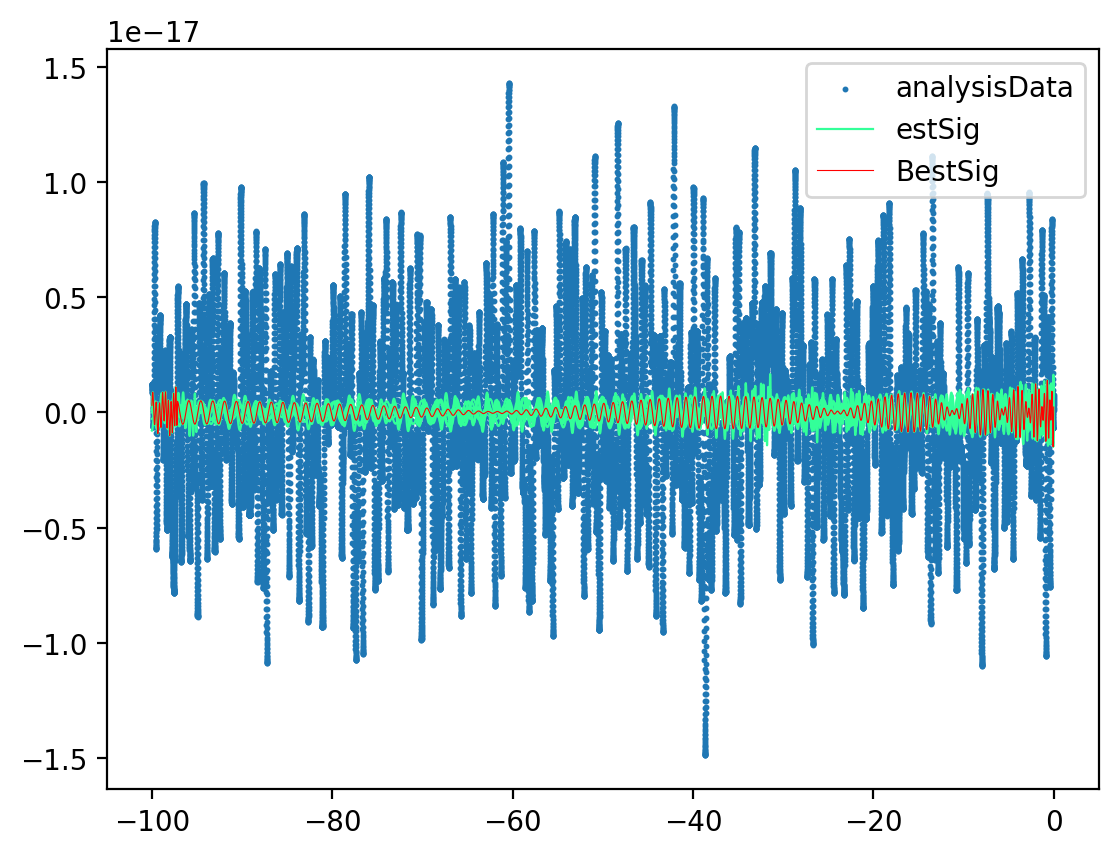

In [6]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         'red',lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
# print(outResults['allRunsOutput'][lpruns]['estSig'])

In [ ]:
# Print estimated parameters
print('Estimated parameters:')
print('bestFitness = {:.4f}'.format(outResults['bestFitness']))
print('r = {:.4f}'.format(outResults['r']))
print('m_c = {:.4f}'.format(outResults['m_c'])) 
print('tc = {:.4f}'.format(outResults['tc']))
print('phi_c = {:.4f}'.format(outResults['phi_c']))
print('mlz = {:.4e}'.format(outResults['mlz']))
print('y = {:.4f}'.format(outResults['y']))

for lpruns in range(nRuns):
    print('\nRun No.{}:'.format(lpruns+1))
    print('bestFitness={:.4f}'.format(outStruct[lpruns]['bestFitness']))
    print('r = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['r']))
    print('m_c = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['m_c']))
    print('tc = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['tc']))
    print('phi_c = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['phi_c']))
    print('mlz = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['mlz']))
    print('y = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['y']))

# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters:
bestFitness = -12.8348
r = 1.4978e+03
m_c = 3.0903e+02
tc = 0.8882
phi_c = 1.5262
mlz = 1.1507e+10
y = 8.3817

Run No.1:
bestFitness=-11.98
r = 1410.8238
m_c = 685.4012
tc = 0.9479
phi_c = 2.1083
mlz = 2.6179e+11
y = 0.1745

Run No.2:
bestFitness=-10.66
r = 1200.5386
m_c = 686.8593
tc = 0.4668
phi_c = 2.3194
mlz = 1.0000e+14
y = 10.0000

Run No.3:
bestFitness=-12.80
r = 1951.3671
m_c = 309.5337
tc = 0.8657
phi_c = 6.0341
mlz = 9.1613e+13
y = 6.8417

Run No.4:
bestFitness=-12.52
r = 1049.4685
m_c = 311.4447
tc = 0.6715
phi_c = 2.8802
mlz = 1.0000e+14
y = 10.0000

Run No.5:
bestFitness=-11.32
r = 2199.9720
m_c = 307.5575
tc = 0.9580
phi_c = 1.0496
mlz = 8.0442e+08
y = 9.0628

Run No.6:
bestFitness=-11.87
r = 1370.2970
m_c = 311.1892
tc = 0.6831
phi_c = 1.4867
mlz = 4.7315e+05
y = 1.7680

Run No.7:
bestFitness=-10.72
r = 1257.6039
m_c = 685.9706
tc = 0.4815
phi_c = 4.0459
mlz = 1.0000e+14
y = 10.0000

Run No.8:
bestFitness=-12.83
r = 1497.8300
m_c = 309.0294
tc = 0.8

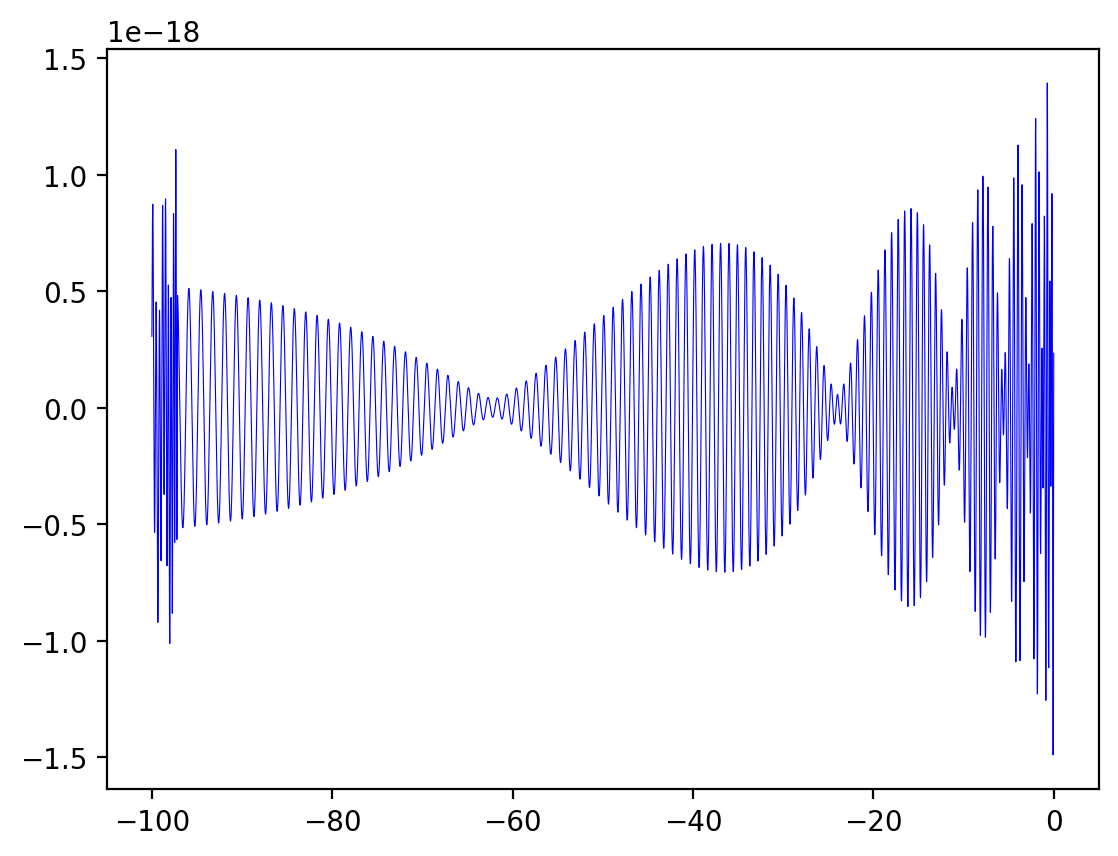

In [8]:
fig = plt.figure(dpi=200)
plt.plot(t, outResults['bestSig'], #label='BestSig',
         'blue',lw=.2*2)
plt.show()